# Introduction 

# Software Imports and Plot Settings 

In [2]:
# then third party libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator, LogLocator
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
# jupyter notebook extras
%matplotlib inline 
%load_ext autoreload
%autoreload 2

# set plotting parameters
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False

# Data Inputs

## Import Load and Generation Data

In [4]:
excel_file = 'SMHS_SBUSD_ESDMrev32c (01_mk, 26May2020).xlsx'
load_sheet = 'Data_Load_15min'
pv_generation_sheet = 'Data_PV_Gen_15min'

In [5]:
load = pd.read_excel(excel_file, sheet_name=load_sheet)
load.columns = ['datetime', 'usage_kwh', 'usage_kw', 'del1', 'del2', 'del3', 'del4']

for column in load.columns:
    if column.startswith('del'):
        del load[column]

In [6]:
pv_generation = pd.read_excel(excel_file, sheet_name=pv_generation_sheet, skiprows=2)
pv_generation.columns = ['datetime', 'del1', 'pv_generation_kw', 'del2', 'del3', 'del4']

for column in pv_generation.columns:
    if column.startswith('del'):
        del pv_generation[column]

In [115]:
model = pv_generation.copy()
model['pv_generation'] = model['pv_generation_kw'] / 4
model['load'] = load['usage_kwh']
del model['pv_generation_kw']

In [116]:
def round_dates(row):
    return row['datetime'].round('1min')
    
model['datetime'] = model.apply(lambda row : round_dates(row), axis=1)

# Model Inputs

In [92]:
tier_1_percent = 0.0284
look_ahead_interval = 96
battery_charging_loss = 0.05
battery_discharging_loss = 0.05
start_peak_time_of_use = 16
end_peak_time_of_use = 21
hold_battery_discharge_until = 16
minimum_forecast_battery_discharge = 1500

battery_power = 355
battery_capacity = 710  # kwh
intervals_per_hour = 4
pv_to_grid_export_threshold = battery_power / (intervals_per_hour * 2)
battery_max_export_15min = battery_power / 4
export_only_during_summer = True

# Resilience Calculations

## Old Complicated Logic
**Idea:** This calculation is unnecessarily complicated. What it effectively does is that it looks ahead in the next 24 hours, and adds all Tier 1 loads between 9pm and the time in the morning when the sun starts shining, and calls this the SOCr. The basic idea here is that any load that any load in the next 24 hours not met by the pv generation in that interval should be added to the SOCr. However, the 9pm cutoff actually interferes with even this basic calculation. Also, this calculation does not account for the fact that the battery can be charged after grid disconnect. <br><br>

## Simplified Logic
**Idea:** The thought behind this calculation is to look at each interval in the next day (the `look_ahead_period`). If the solar generation does not cover the total tier 1 load during this period, we add that load to the SOCr value. This calculation does not account for the fact that the battery can be charged after grid disconnect.<br><br>
**Logic (Pseudo code):** 
```
At given Interval:
SOCr = 0

For each interval in look ahead period:

    If (PV generation < Tier 1 Load):
    
        Add Tier 1 Load to SOCr
```

In [93]:
def is_battery_reserve_needed(row):
    return row['pv_generation'] < row['load'] * tier_1_percent

model['is_battery_needed'] = model.apply(lambda row : is_battery_reserve_needed(row), axis=1)

model['old_socr'] = (
    (model['load'] * model['is_battery_needed'])
    .iloc[::-1].rolling(look_ahead_interval, min_periods=1)
    .sum().iloc[::-1] * tier_1_percent)

## New SOCr

**Idea:** For the interval we are calculating at, assume grid disconnection happens at that interval. We need to account for how the battery gets charged after grid disconnection. <br>
For each interval in the next day (the `look_ahead_period`) we first see whether the battery has charged enough (after disconnection) to power the critical Tier 1 load. If not, we add the load to the SOCr value. We then add PV generation in that interval to the battery charge (after disconnection).
<br><br>
**Logic (Pseudo code):** 
```
At given Interval:
SOCr = 0
battery charge after disconnect = 0

For each interval in look ahead period:

    If (battery charge after disconnect > Tier 1 Load):
    
        subtract tier 1 load from battery charge
    
    Else (battery charge after disconnect <= Tier 1 Load):
    
        Add Tier 1 load - remaining battery to SOCr
        Reset battery charge after disconnect to 0
        
    Add PV generation in interval to battery charge after disconnect
    
```

In [94]:
def calculate_socr():

    load = model['load'].to_numpy()
    pv = model['pv_generation'].to_numpy()
    socr = np.zeros(len(model))

    for i in range(len(load)):
        battery = 0
        reserve_needed = 0

        for j in range(i, min(i + look_ahead_interval, len(load))):

            #print(j)

            tier_1_load = load[j] * tier_1_percent

            if (battery > tier_1_load):
                battery -= tier_1_load
                #print(j)
            else:
                reserve_needed += (tier_1_load - battery)
                battery = 0

            battery = min((pv[j] + battery), battery_capacity)

           # print(reserve_needed, old_reserve_needed)

        socr[i] = reserve_needed
        
    return socr

model['new_socr'] = calculate_socr()

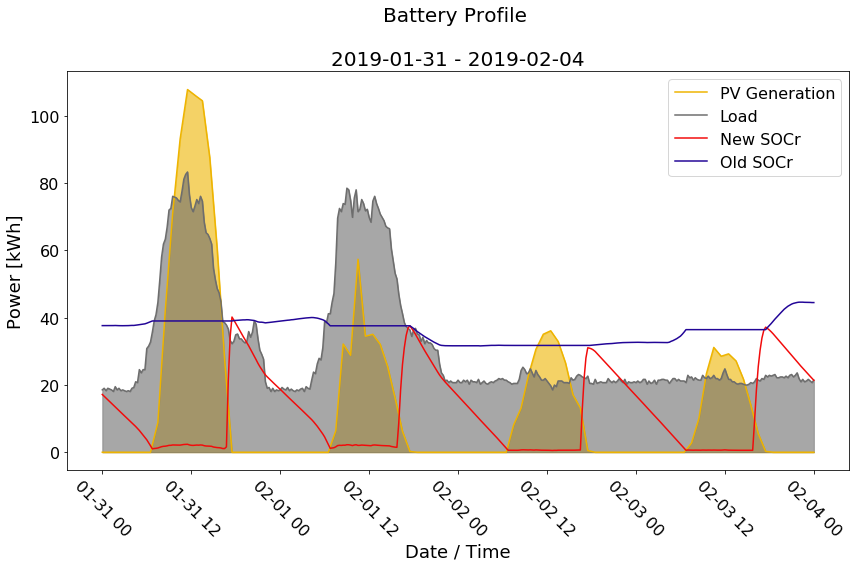

In [95]:
start_date = '2019-01-31'
end_date = '2019-02-04'

df = model[(model['datetime'] >= '2019-01-31') & (model['datetime'] <= '2019-02-04')]

plt.figure()
plt.plot(df['datetime'], df['pv_generation'], color='#eeb400', label='PV Generation')
plt.fill_between(df['datetime'], df['pv_generation'], color='#eeb400', alpha = 0.6)
plt.plot(df['datetime'], df['load'], color='#6d6d6d', label='Load')
plt.fill_between(df['datetime'],df['load'], color='#6d6d6d', alpha = 0.6)
plt.plot(df['datetime'], df['new_socr'], color='#f20b0b', label='New SOCr')
plt.plot(df['datetime'], df['old_socr'], color='#220597', label='Old SOCr')
plt.title(f'Battery Profile \n\n{start_date} - {end_date}')
plt.xlabel('Date / Time')
plt.xticks(rotation='315')
plt.ylabel('Power [kWh]')
plt.legend()
plt.tight_layout()
#plt.savefig('new_socr.png')

# PV and Load Calculations
In this section, we calculate how much PV goes to the power the load, how much is in excess of the load, or how much load is not met by the PV generation. We can do this without knowing anythin about the battery since our solar power will first go to power our load before any battery charging or grid dispatch.

## PV to Load

Logic: If PV generation is less than load, all of it goes to the load. If PV generation is more than the load, it convers the entire load, and then there is excess.
<br><br>
Pseudocode:
```
For each interval:
Return minimum of load and pv generation
```

In [96]:
def pv_to_load(row):
    return min(row['load'], row['pv_generation'])

model['pv_to_load'] = model.apply(lambda row : pv_to_load(row), axis=1)

## Unserved Load
Logic: Any load not met by solar power
<br><br>
Pseudocode:
```
For each interval:
Return load - pv_to_load.
```

In [97]:
model['unserved_load'] = model['load'] - model['pv_to_load']

## Excess PV
Logic: Any generation in excess of the elctrical load.
<br><br>
Pseudocode:
```
For each interval:
Return maximum of solar generation minus load, or zero.
```

In [98]:
def excess_pv(row):
    return max(row['pv_generation'] - row['load'], 0)

model['excess_pv'] = model.apply(lambda row : excess_pv(row), axis=1)

# Battery Calculations
Now we can look at how the battery interacts with solar generation and the grid. These calculations are really the result of design decisions, and might need to be changed for your application.

The battery can do multiple things. It must maintain a minimum amount of charge for resilience purposes, the State of Charge needed for Reslience or SOCr. It can power the electrical load, it can be charged by both the PV system and the grid and it can dispatch to the grid.

## Battery State of Charge
We start with the Battery State of Charge (SOC), basically, the amount of energy a battery has stored in it.

Logic: The battery charge in the current inverval is the battery charge in the previous interval, plus energy transfered to the battery from the pv system, minus the battery charge that went to the electrical load and the grid in the previous interval.

In [99]:
def get_battery_soc(i):
    ''' Return the battery state of charge in interval i '''
    if (i == 1):
        return battery_soc_initial
    else:
        return (battery_SOC[i - 1] - battery_to_load[i - 1] - battery_to_grid[i - 1] + battery_charge_from_pv[i - 1])

## Battery Usable State of Charge
Batteries lose energy each time they charge and discharge. So, the usable energy is actually less than the charge

Logic: usable SOC is SOC minus discharge losses (`battery_discharge_loss`)

In [100]:
def get_battery_soc_usable(i):
     return battery_SOC[i] * (1 - battery_discharging_loss)

## Battery to Load
We start with how much battery power is used to power the load. 

### Old Calculation
Idea: The battery only discharges after a certain hour in the day (to optimize for peak pricing) and when the 2 day ahead solar forecast is above a certain minimum. Also, the battery charge must be greater than the SOCr value plus the unserved load.
<br><br>
Pseudocode: 

```
If (After certain hour of the day (discharge threshold) AND
    2 day solar forecast must be greater than certain amount AND
    Battery discharge potential greater than SOCr and unserved load):
    
    return unserved load amount
    
Else

    return 0
```

In [101]:
def battery_to_load_old(i):
    if ((model['datetime'][i - 1].hour >= hold_battery_discharge_until) and
        (model['two_day_forecast'][i - 1] > minimum_forecast_battery_discharge) and
        (battery_discharge_potential[i] > (model['unserved_load'][i - 1] + model['old_socr'][i - 1]))):
        
        return model['unserved_load'][i - 1]
        
    else:
        return 0

### New Calculation
Changes: The 2 day ahead solar forecast isn't necessary. Also, the battery should be able to charge power the load partially even if it can't power the full load in that interval. Also we need to account for the maximum battery export (typically this is not a problem, but a good safety to add.)

Idea: The battery only discharges after a certain hour in the day (to optimize for peak pricing). Also, the battery can only use capacity greater than its SOCr.
<br><br>
Pseudocode: 

```
If (After certain hour of the day (discharge threshold) AND
    usable battery SOC is greater than SOCr):
    
    return min(unserved load amount, usable battery SOC in excess of SOCr, maximum interval export threshold)
    
Else

    return 0
```

In [102]:
def battery_to_load_new(i):
    if ((model['datetime'][i - 1].hour >= hold_battery_discharge_until) and
        (battery_discharge_potential[i] > (model['unserved_load'][i - 1] + model['old_socr'][i - 1]))):
        
        return min(model['unserved_load'][i - 1], (battery_discharge_potential[i] - model['old_socr'][i - 1]),
                  battery_max_export_15min)
        
    else:
        return 0

## Battery to Grid
After the battery powers the load, we may want to export battery power to the grid under certain conditions. Again, this is the result of design choices. Currently, we can decide whether to only export in the summer, and during peak hours, so we need to make some initial calculations first:

### Peak Period

In [103]:
def is_peak(row):
    return row['datetime'].hour >= start_peak_time_of_use and row['datetime'].hour < end_peak_time_of_use

model['is_peak'] = model.apply(lambda row : is_peak(row), axis=1)

### 2 Day Ahead Solar Forecast

In [104]:
two_day_intervals = 192

model['two_day_forecast'] = (
    model['pv_generation']
    .iloc[::-1].rolling(two_day_intervals, min_periods=1)
    .sum().iloc[::-1])

### Peak Intervals Left
Intervals left in peak period

In [105]:
def peak_intervals_left(row):
    if is_peak(row):
        return round(((end_peak_time_of_use - row['datetime'].hour) * 4) - (row['datetime'].minute / 15), 0)
    else:
        return 0
        

model['peak_intervals_left'] = model.apply(lambda row : peak_intervals_left(row), axis=1)

### Is it Summer?
Determine if it is summer for battery export to grid

In [106]:
summer_start = pd.to_datetime('20190601', format='%Y%m%d', errors='ignore')
summer_end = pd.to_datetime('20190901', format='%Y%m%d', errors='ignore')

model['is_summer'] = ((model['datetime'] >= summer_start) & (model['datetime'] < summer_end))

### Current Calculation

Idea: We can set the model to only export during the summer. We also only export during a peak period during the day (for best prices), we only export when PV to grid export is less than a certain amount, when the 2 day ahead forecast is above a certain amount, and when the battery charge is sufficient to maintain SOCr and cover any unserved loads.

Currently, we also distribute how we export energy over the remaining peak intervals. This doesn't make too much sense since the battery can continue to get charged in the remaining peak period. 

Also, we currently split the calculation into battery to grid desired and battery to grid actual (accounting for the discharge losses) which is unnecessary.

Pseudocode:
```
If Battery only exports in summer peak:
    If not peak period:
        return 0
    else:
        if (it is summer AND
             battery SOC > SOCr + unserved load AND
             2 day solar forecast > threshhold AND
             PV to Grid export less than threshhold):
             
            return SOC - SOCr - battery to load / timestamp left in peak period
        else
            return 0
else:
    if not peak period:
        return 0
    else:
        if (SOC > battery to load + SOCr AND
            2 day solar forecast > threshhold AND
            PV to Grid export less than threshhold):
            
            return SOC - SOCr - battery to load / timestamp left in peak period
        else:
            
            return 0
            
```

### Optimization

We can optimize and simplify this same logic significantly. Here is an optimized version that does the same thing.
        
Pseudocode:

```
if ((!summer_peak or summer) AND
    peak period AND
    SOC > battery to load + SOCr AND
    2 day solar forecast > threshhold AND
    PV to Grid export less than threshhold):
    
    return SOC - SOCr - battery to load / timestamp left in peak period

else

    return 0
```

In [107]:
def get_battery_to_grid_desired(i):
    
    if (i == 1):
        previous_pv_to_battery = pv_to_battery_initial
    else:
        previous_pv_to_battery = pv_to_battery[i - 1]

    if (((not export_only_during_summer) or model['is_summer'][i - 1]) and
        model['is_peak'][i - 1] and
        (battery_SOC[i] > (battery_to_load[i] + model['old_socr'][i - 1])) and
        (model['two_day_forecast'][i - 1] > minimum_forecast_battery_discharge) and
        (previous_pv_to_battery < pv_to_grid_export_threshold)):
        
        return ((battery_SOC[i] - model['old_socr'][i - 1]
                 - battery_to_load[i]) / model['peak_intervals_left'][i - 1])
        
    else:
        
        return 0
    
def get_battery_to_grid_actual(i):
    
    return (max(0, min((battery_to_grid_desired[i] - battery_to_load[i]), battery_max_export_15min)))

### New Calculation
Changes: 

1. The 2 day ahead solar forecast isn't necessary.
2. We currently have a bug and look at pv to battery instead of pv to grid
3. We need to look at usable Battery SOC, not the ideal SOC when determining if we have sufficient power to export
4. We should just export as much as we can in any given interval rather than trying to split the battery amount by peak period intervals remaining.

Idea: We can set the model to only export during the summer. We also only export during a peak period during the day (for best prices), we only export when PV to grid export is less than a certain amount, and when the battery charge is sufficient to maintain SOCr and cover any unserved loads.

We export as much excess battery power as we can (considering battyer max export amounts)


Pseudocode:

```
if ((!summer_peak or summer) AND
    peak period AND
    SOC > battery to load + SOCr AND
    PV to Grid export less than threshhold):
    
    return min(SOC - SOCr - battery to load, maximum interval export threshold)

else

    return 0
```

In [108]:
def get_battery_to_grid_new(i):

    if (((not export_only_during_summer) or model['is_summer'][i - 1]) and
        model['is_peak'][i - 1] and
        (battery_discharge_potential[i] > (battery_to_load[i] + model['old_socr'][i - 1])) and
        (pv_to_battery[i - 1] < pv_to_grid_export_threshold)):
        
        return min((battery_SOC[i] - model['old_socr'][i - 1] - battery_to_load[i]), battery_max_export_15min)
        
    else:
        
        return 0

## PV to Battery

Basically, any excess solar generation (after it meets electrical loads) should charge the battery before being exported to the grid. 

### Current Calculation

Idea: We first check and see if the battery has been fully charged today. 

#### Did battery reach max today?
Current Logic:
```
If 12am:

    False
    
Else:

    return (Battery SOC % > 99% OR previous interval was True)
    
```

In [109]:
def did_battery_reach_peak_today(i):

    return (not((model['datetime'][i - 1].hour == 0) and (model['datetime'][i - 1].minute == 0)) and
           (((battery_SOC[i] / battery_capacity) > 0.99) or (battery_reached_peak_today[i - 1] == True)))

#### Transfer Excess PV to Battery

Then any excess pv is transferred to the battery (keeping in mind the maximum export limit of the battery).

**Current Logic:**
```

If (SOCr not reached max today):

    If ((Battery SOC - battery to load - battery to grid + excess pv <= battery capacity) OR
        (Battery SOC - battery to load - battery to grid + battery max 15 min export capacity <=
        battery capacity)):
        
        return max(0, min(excess pv, battery max 15 min export capacity))
        
    Else:
    
        return max(battery capacity - battery SOC - battery to load - battery to grid)
        
Else:

    return 0
```

**Optimitized Logic**
```
If (SOCr not reached max today):

    min(excess pv, battery max 15 min export capacity,
    (battery capacity - battery SOC - battery to load - battery to grid))

Else:

    return 0   
    
```

In [110]:
def get_pv_to_battery(i):

    if not battery_reached_peak_today[i]:
        
        return min(model['excess_pv'][i - 1], battery_max_export_15min,
                   (battery_capacity - battery_SOC[i] - battery_to_load[i] - battery_to_grid[i]))
        
    else: 
        return 0

### New Calculation
Changes: 

1. Optimize the logic
2. Remove the check for whether SOC reached its max today. This is unnecessary, since we can look at the battery SOC at every interval directly.

Idea: Any excess solar generation, after it has met electrical loads, should be transfered to the battery. So, we charge the battery as much as we can with excess pv, considering remaining battery space and max import restrictions in thatr interval.

Pseudocode:
```
Return  max(0, min(excess pv, battery max 15 min export capacity,
                (battery capacity - battery SOC - battery to load - battery to grid)))
```

## Battery charge from PV
We need to account for the fact that there is a loss of energy when the battery is charged

Logic: Battery charge from PV is PV power to battery minus charging losses

In [111]:
def get_battery_charge_from_pv(i):
    return pv_to_battery[i] * (1 - battery_charging_loss)

In [112]:
length = len(model)
battery_to_load = np.empty(length + 1)
battery_to_grid = np.empty(length + 1)
battery_to_grid_desired = np.empty(length + 1)
pv_to_battery = np.empty(length + 1)
battery_charge_from_pv = np.empty(length + 1)
battery_SOC = np.empty(length + 1)
battery_discharge_potential = np.empty(length + 1)
battery_reached_peak_today = np.empty(len(model) + 1)

battery_soc_initial = 0
pv_to_battery_initial = 0

# initial values
battery_to_load[0] = 0
battery_to_grid[0] = 0
battery_to_grid_desired[0] = 0
pv_to_battery[0] = 0
battery_charge_from_pv[0] = 0
battery_SOC[0] = 91.36
battery_discharge_potential[0] = battery_SOC[0] * (1 - battery_discharging_loss)
battery_reached_peak_today[0] = False

for i in range(len(model)):
    # battery SOC
    #battery_SOC[i + 1] = (battery_SOC[i]
     #                 - battery_to_load[i]
      #                - battery_to_grid[i]
       #               + battery_charge_from_pv[i])
    
    battery_SOC[i + 1] = get_battery_soc(i + 1)
    
    #battery_discharge_potential[i + 1] = battery_SOC[i + 1] * (1 - battery_discharging_loss)
    
    battery_discharge_potential[i + 1] = get_battery_soc_usable(i + 1)
    
    # calculate battery charge to load
    #if ((model['datetime'][i].hour >= hold_battery_discharge_until) and
    #    (model['two_day_forecast'][i] > minimum_forecast_battery_discharge) and
    #    (battery_discharge_potential[i + 1] > (model['unserved_load'][i] + model['old_socr'][i]))):
        
    #    battery_to_load[i + 1] = model['unserved_load'][i]
        
    #else:
    #    battery_to_load[i + 1] = 0
        
    battery_to_load[i + 1] = battery_to_load_old(i + 1)
        
    # calculate battery to grid desired
    #if (((not export_only_during_summer) or model['is_summer'][i]) and
    #    model['is_peak'][i] and
    #    (battery_SOC[i + 1] > (battery_to_load[i + 1] + model['old_socr'][i])) and
    #    (model['two_day_forecast'][i] > minimum_forecast_battery_discharge) and
    #    (pv_to_battery[i] < pv_to_grid_export_threshold)):
    #    
    #    battery_to_grid_desired[i + 1] = ((battery_SOC[i + 1] - model['old_socr'][i]
            #                               - battery_to_load[i + 1]) / model['peak_intervals_left'][i])
        
    #else:
        
    #    battery_to_grid_desired[i + 1] = 0
        
    battery_to_grid_desired[i + 1] = get_battery_to_grid_desired(i + 1)
    
    # calculate actual battery to grid
    #battery_to_grid[i + 1] = (max(0, min((battery_to_grid_desired[i + 1] - battery_to_load[i + 1]),
     #                                    battery_max_export_15min)))
    
    battery_to_grid[i + 1] = get_battery_to_grid_actual(i + 1)
    
    
    # did battery reach peak today
    #if (model['datetime'][i].hour == 0 and model['datetime'][i].minute == 0):
    #    battery_reached_peak_today[i + 1] = False
    #else:
    #    battery_reached_peak_today[i + 1] = (((battery_SOC[i + 1] / battery_capacity) > 0.99) or
     #                                        (battery_reached_peak_today[i] == True))
        
    battery_reached_peak_today[i + 1] = did_battery_reach_peak_today(i + 1)
     
    
    # calculate pv to battery
    #if not battery_reached_peak_today[i + 1]:
        
    #    pv_to_battery[i + 1] = min(model['excess_pv'][i], battery_max_export_15min,
     #                              (battery_capacity - battery_SOC[i + 1] -
      #                              battery_to_load[ i + 1] - battery_to_grid[i + 1]))
        
    #else:
        
     #   pv_to_battery[i + 1] = 0
        
    pv_to_battery[i + 1] = get_pv_to_battery(i + 1)

    # calculate battery charge from pv
    #battery_charge_from_pv[i + 1] = pv_to_battery[i + 1] * (1 - battery_charging_loss)
    
    battery_charge_from_pv[i + 1] = get_battery_charge_from_pv(i + 1)

In [113]:
model['battery_to_load'] = battery_to_load[1:]
model['battery_to_grid'] = battery_to_grid[1:]
model['battery_to_grid_desired'] = battery_to_grid_desired[1:]
model['pv_to_battery'] = pv_to_battery[1:]
model['battery_charge_from_pv'] = battery_charge_from_pv[1:]
model['battery_SOC'] = battery_SOC[1:]
model['battery_discharge_potential'] = battery_discharge_potential[1:]
model['battery_reached_peak_today'] = battery_reached_peak_today[1:]

In [114]:
model[33230:33231]

,datetime,pv_generation_kw,pv_generation,load,is_battery_needed,old_socr,new_socr,pv_to_load,unserved_load,excess_pv,...,peak_intervals_left,is_summer,battery_to_load,battery_to_grid,battery_to_grid_desired,pv_to_battery,battery_charge_from_pv,battery_SOC,battery_discharge_potential,battery_reached_peak_today
33230,2019-12-13 03:30:00,0.0,0.0,17.100113,True,33.728262,9.842825,0.0,17.100113,0.0,...,0.0,False,0.0,0.0,0.0,0.0,0.0,40.522612,38.496482,0.0
